In [1]:
import pandas as pd
import numpy as np

import itertools

from os import listdir

from sklearn import metrics
from scipy import stats, special

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import CenteredNorm
%matplotlib inline

In [2]:
def merge_results_frames(df,df2):
    for idx,r in df.iterrows():
        g = r['gamma']
        p = r['bias']
        for col in df.columns:
            if col == 'gamma' or col == 'bias':
                continue
            df.loc[(df['gamma']==g) & (df['bias']==p),col]+=df2.loc[(df2['gamma']==g) & (df2['bias']==p),col]

def str2list(strarray):
    return [float(x) for x in strarray.strip('[] ').split()]

def df_str2list(df):
    for col in df.columns:
        if col == 'gamma' or col == 'bias':
            continue
        df[col] = df[col].apply(str2list)

In [3]:
def expand_shared_properties_in_dict(df):
    dictall = {}
    for _,row in df.iterrows():
        for col in df.columns:
            if col in ['gamma','bias']:
                rowlist = [row[col]]*len(row['Derrida'])
            else:
                rowlist = row[col]
            if col in dictall:
                dictall[col] += rowlist
            else:
                dictall[col] = rowlist.copy()
    return dictall

def append_extra_columns(dictall):
    dfall = pd.DataFrame(dictall)

    dfall['entropy'] = -(dfall['bias']*np.log2(dfall['bias']))-((1-dfall['bias'])*np.log2(1-dfall['bias']))
    dfall['variance'] = dfall['bias']*(1-dfall['bias'])

    dfall['avgS']=dfall['avgKe']-dfall['avgKc']
    dfall['regime']=(dfall['Derrida']>1).astype(int) - (dfall['Derrida']<1).astype(int)
    dfall['avgH'] = -dfall['avgP']*np.log2(dfall['avgP'])-(1-dfall['avgP'])*np.log2(1-dfall['avgP'])
    dfall['avgV'] = (1-dfall['avgP'])*dfall['avgP']
    
    return dfall

In [4]:
REGENERATE_DATA=False # takes a couple of minutes to regenerate data frame from individual csv files
results_dir_dict={20:'Results20/',50:'Results50/',100:'Results100/',200:'Results200/'}
if REGENERATE_DATA:
    results_dir_dict={20:'Results20/',50:'Results50/',100:'Results100/',200:'Results200/'}
    dfall = pd.DataFrame()
    for N,results_dir in results_dir_dict.items():
        first_in_N = True
        for filename in listdir(results_dir):
            if first_in_N:
                df = pd.read_csv(results_dir+filename)
                df_str2list(df)
                first_in_N = False
            else:
                df2 = pd.read_csv(results_dir+filename)
                df_str2list(df2)
                merge_results_frames(df,df2)
        dictall = expand_shared_properties_in_dict(df)
        dfallN = append_extra_columns(dictall)
        dfallN['N']=N
        dfall = pd.concat([dfall,dfallN],axis=0)
    dfall.to_csv('full_RBN_data.csv')           
else:
    dfall=pd.read_csv('full_RBN_data.csv')
Nvals = results_dir_dict.keys()
dfall['gamma'] = dfall['gamma'].round(2) # to fix some entries recorded, e.g., like 2.100000005
dfall['bias'] = dfall['bias'].round(2)
# shuffle data
dfall=dfall.sample(frac=1.0)

dfall

Unnamed: 0  gamma  bias  Derrida   avgK  medK     avgKe  medKe  \
39879         3879    1.6  0.05    0.239  2.980   1.0  0.986050    0.0   
36903          903    1.5  0.15    0.911  3.500   2.0  1.957869    1.0   
123760       15760    1.9  0.20    0.628  1.990   1.0  0.909084    0.0   
42706         6706    1.6  0.40    1.398  3.020   1.0  1.986684    1.0   
136120       28120    2.2  0.40    0.972  2.075   1.0  1.314311    1.0   
...            ...    ...   ...      ...    ...   ...       ...    ...   
142882       34882    2.4  0.35    0.713  1.620   1.0  0.881554    1.0   
79062         7062    1.6  0.45    1.301  2.720   1.0  1.746820    1.0   
22165        22165    2.1  0.10    0.203  1.900   1.0  0.426304    0.0   
137660       29660    2.3  0.15    0.492  1.920   1.0  0.754266    0.0   
13277        13277    1.8  0.35    0.786  1.900   1.0  1.009115    1.0   

           avgKc  medKc      avgP   entropy  variance      avgS  regime  \
39879   0.731264    0.0  0.050764  0.286397    0.0475  0.254785      -1   
36903   1.012751    0.0  0.148548  0.609840    0.1275  0.945118      -1   
123760  0.284812    0.0  0.198264  0.721928    0.1600  0.624272      -1   
42706   0.570844    0.0  0.401096  0.970951    0.2400  1.415840       1   
136120  0.286462    0.0  0.397607  0.970951    0.2400  1.027849      -1   
...          ...    ...       ...       ...       ...       ...     ...   
142882  0.142987    0.0  0.346654  0.934068    0.2275  0.738567      -1   
79062   0.470665    0.0  0.450902  0.992774    0.2475  1.276155       1   
22165   0.223179    0.0  0.080645  0.468996    0.0900  0.203125      -1   
137660  0.244373    0.0  0.150441  0.609840    0.1275  0.509893      -1   
13277   0.168490    0.0  0.333333  0.934068    0.2275  0.840625      -1   

            avgH      avgV    N  
39879   0.289634  0.048187   50  
36903   0.606195  0.126482   50  
123760  0.718442  0.158955  200  
42706   0.971588  0.240218   50  
136120  0.969534  0.239516  200  
...          ...       ...  ...  
142882  0.931045  0.226485  200  
79062   0.993033  0.247589  100  
22165   0.404448  0.074142   20  
137660  0.610942  0.127808  200  
13277   0.918296  0.222222   20  

[144000 rows x 18 columns]

In [5]:
def kmean(gamma,cutoff=None):
    if cutoff is None:
        return special.zeta(gamma-1)/special.zeta(gamma)
    else:
        ks = np.arange(1,cutoff+1).astype(float)
        return np.sum(ks**(1-gamma)) / np.sum(ks**(-gamma))

/tmp/ipykernel_7009/3696492960.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


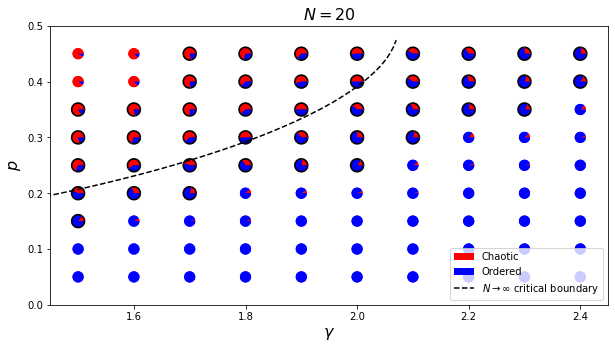

/tmp/ipykernel_7009/3696492960.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


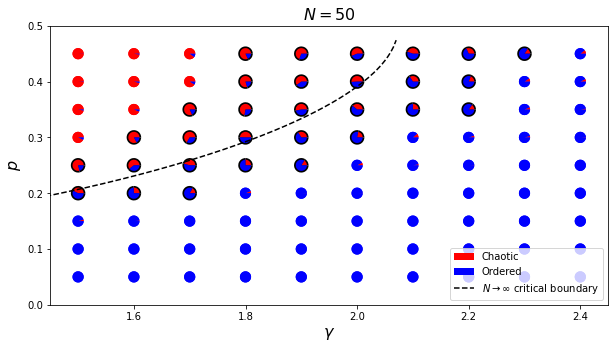

/tmp/ipykernel_7009/3696492960.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


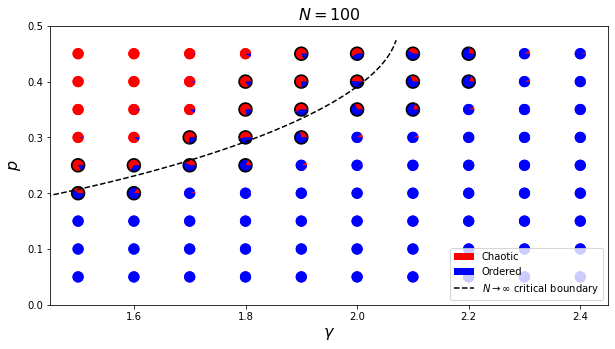

/tmp/ipykernel_7009/3696492960.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


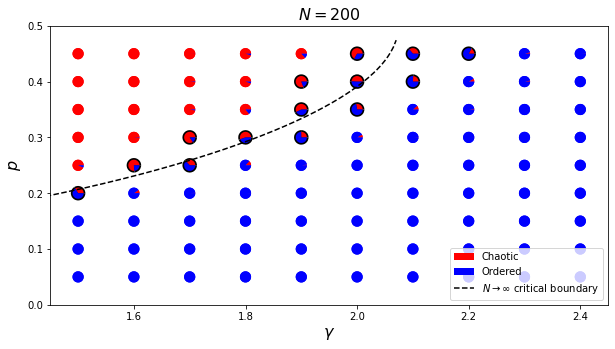

In [6]:
biases = np.arange(0.05,0.5,0.05).round(2)
gammas = np.arange(1.5,2.5,0.1).round(2)
fs=16
for N in Nvals:
    fig, ax = plt.subplots(figsize=(10, 10),facecolor='white')
    
    xrange = np.arange(1.4, 2.6, 0.005)
    ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--') 
    
    for g,p in itertools.product(gammas,biases):
        g=g.round(2)
        p=p.round(2)
        ones = (dfall[(dfall['N'] == N) & (dfall['gamma'] == g) & (dfall['bias'] == p)]['Derrida']>1).mean()
        ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        if ones > 0.85 or ones < 0.15:
            ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        else:
            ax.pie([ones, 1-ones], center=(g, p), radius=0.013, colors=['k', 'k'], frame=True)
            ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        ax.set_xlim(1.45,2.45)
        ax.set_ylim(0,0.5)
        #ones = [derrida > 1 for derrida in row['Derrida']]
        

    legend_elements = [Patch(facecolor='r', label='Chaotic'), Patch(facecolor='b', label='Ordered'), Line2D([0],[0],color='k',linestyle='--',label=r'$N\rightarrow\infty$ critical boundary')]
    plt.title(f'$N=${N}',fontsize=fs)
    plt.xlabel('$\gamma$',fontsize=fs)
    plt.ylabel('$p$',fontsize=fs)
    ax.legend(handles=legend_elements, loc='lower right')
    plt.show()

In [97]:
from scipy.optimize import curve_fit
def powerlaw(x,c,m,b):
    return c*x**m + b

def linear_law(x, m, b):
    return m*x + b

def critical_kappa(rho,c,m,b):
    return (1/rho)*((1-b)/c)**(1/m)

def critical_kappa_lin(rho,m,b):
    return (1-b)/(m*rho)

def mse(x,y,f):
    return np.nanmean((f(x)-y)**2)

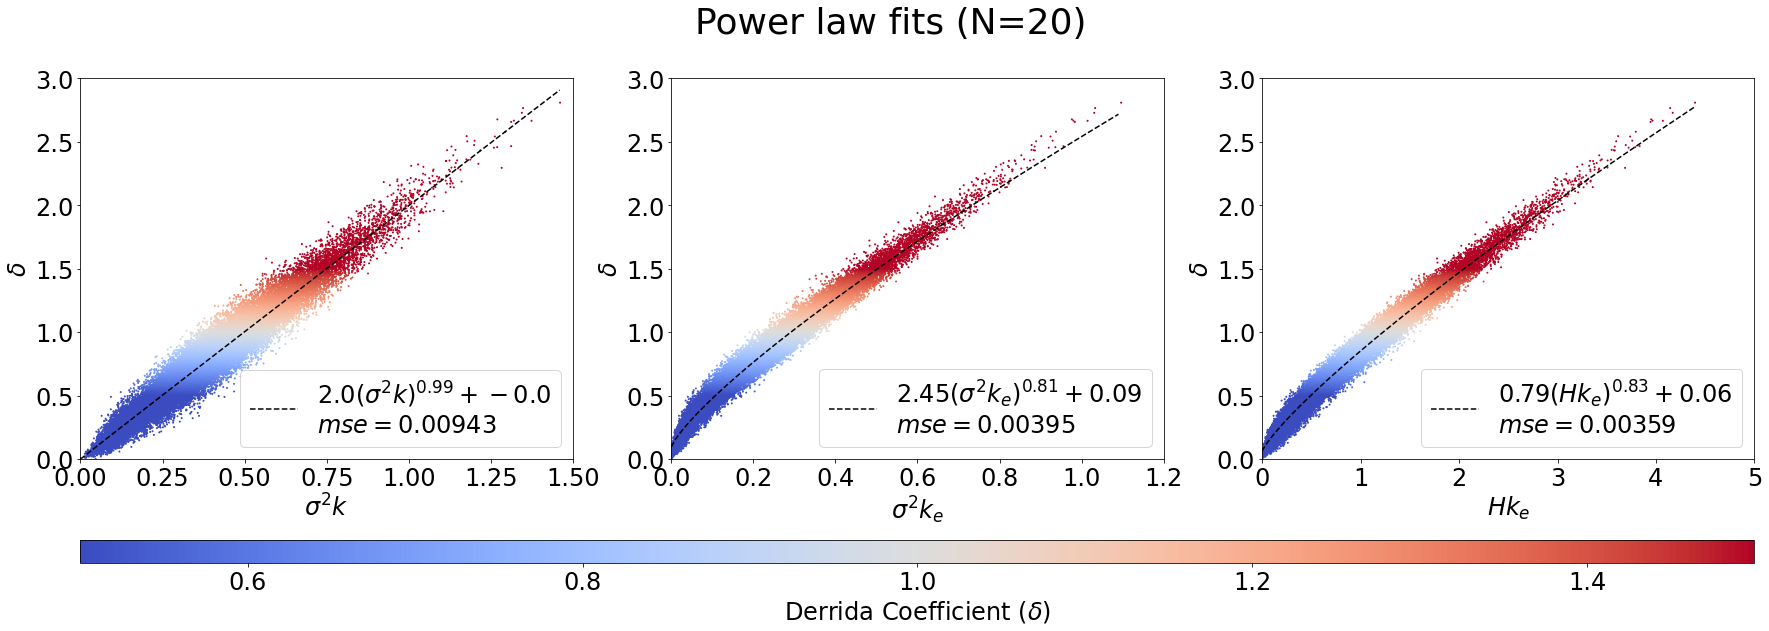

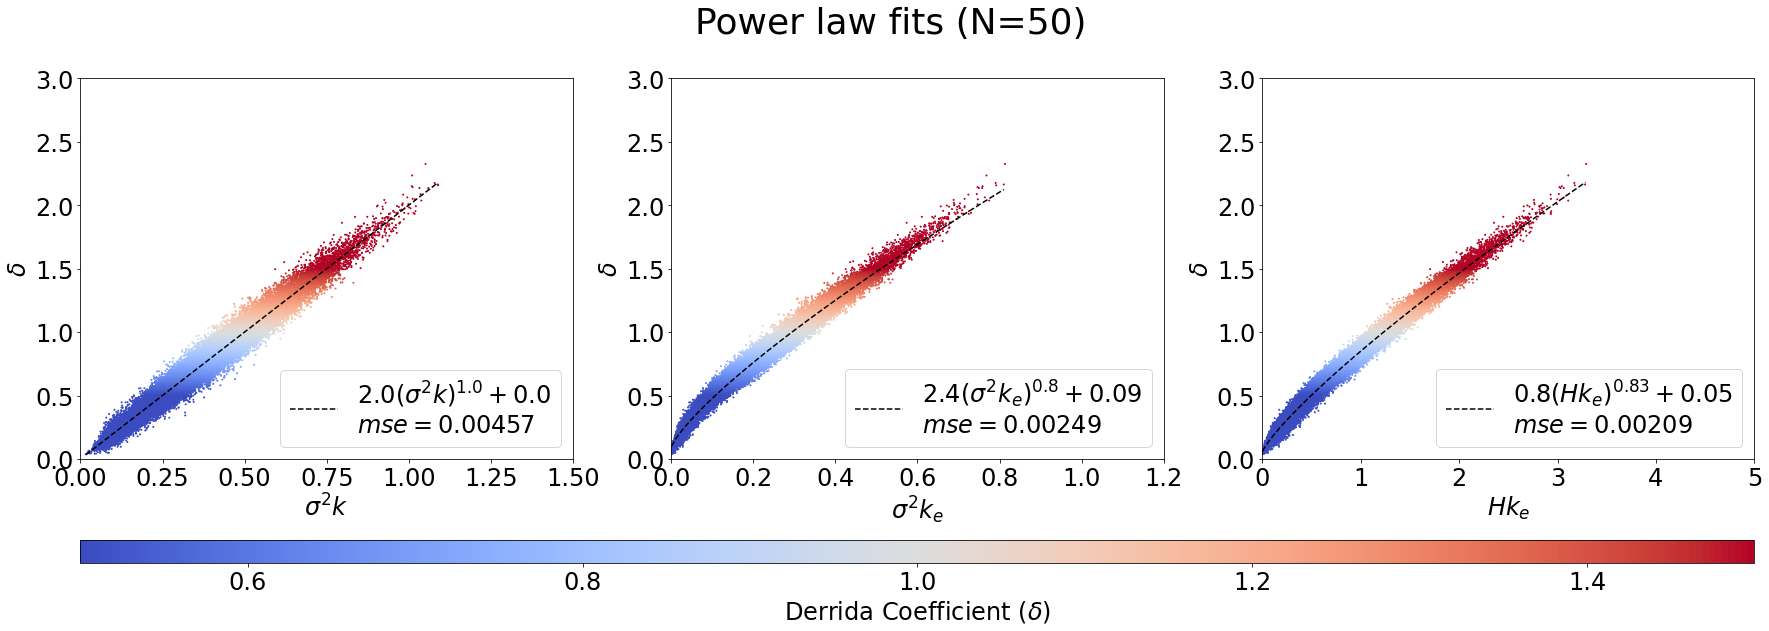

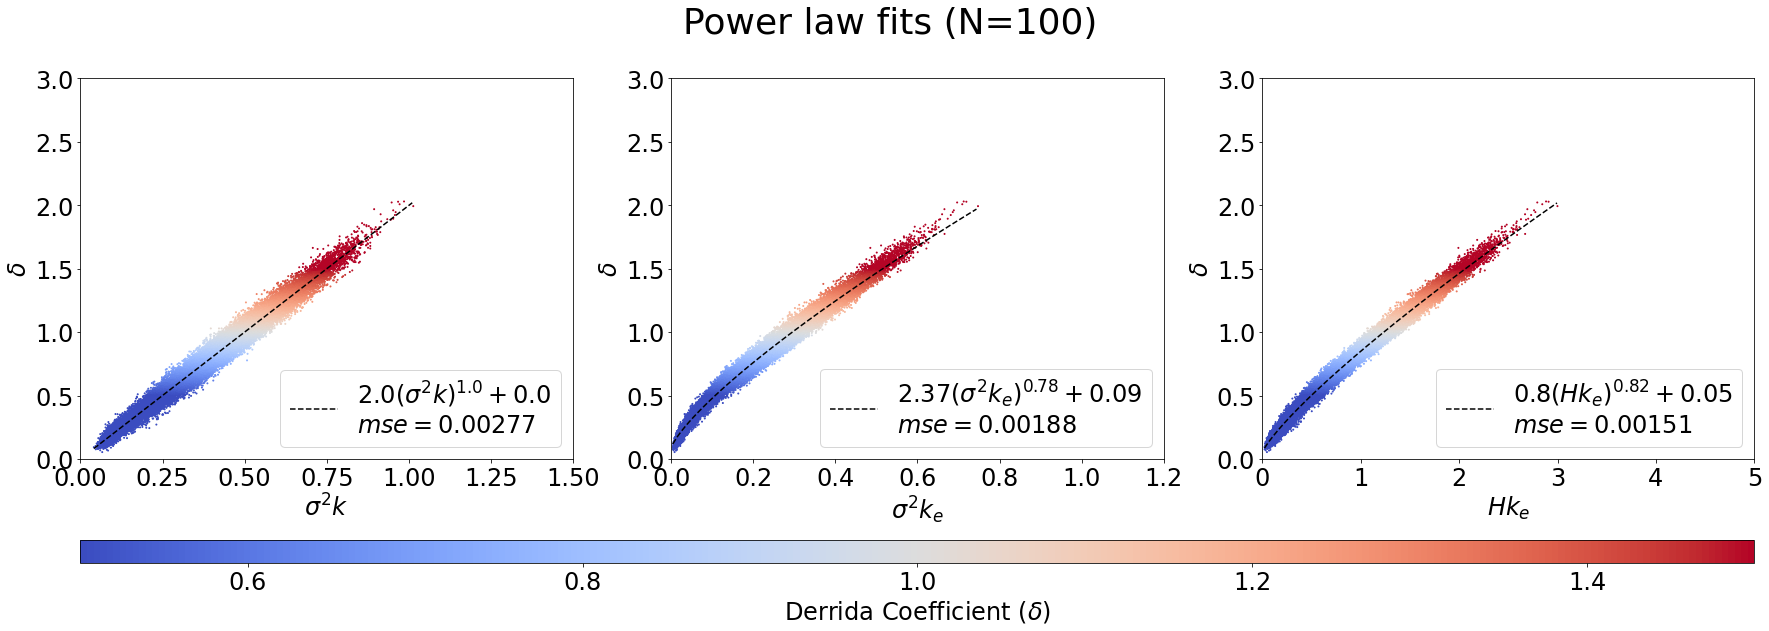

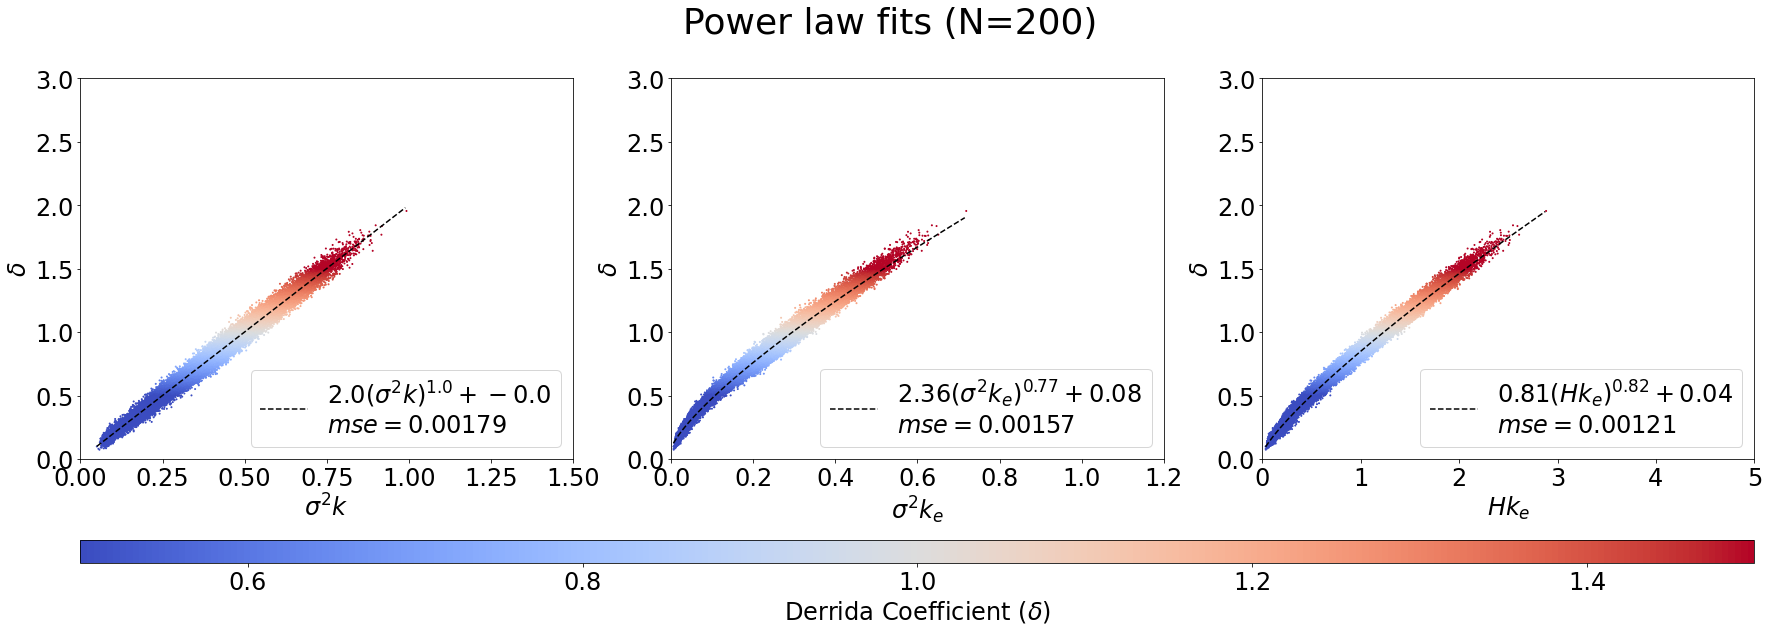

In [95]:
Nvals_test=[20,50]
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2 k$",fontsize=fs)
    ax[0].set_ylabel("$\delta$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_ylim(0,3)
    ax[0].set_xlim(0,1.5)
    
    x=dfN['avgKe']*dfN['avgV']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k_e)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2 k_e$",fontsize=fs)
    ax[1].set_ylabel("$\delta$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3)
    ax[1].set_xlim(0,1.2)
    
    x=dfN['avgKe']*dfN['avgH']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(Hk_e)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$Hk_e$",fontsize=fs)
    ax[2].set_ylabel("$\delta$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3)
    ax[2].set_xlim(0,5)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Power law fits ({N=})',fontsize=fs*1.5)
    plt.show()

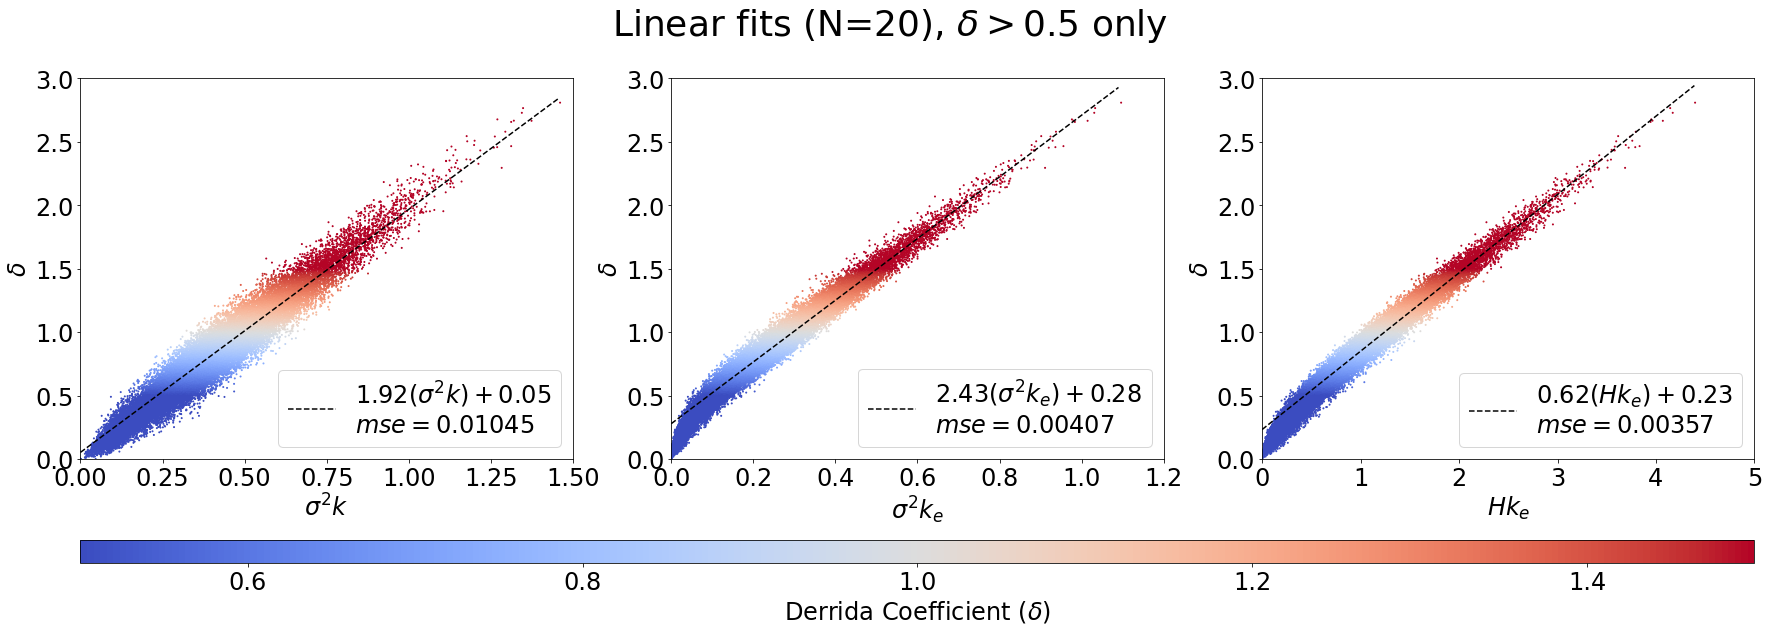

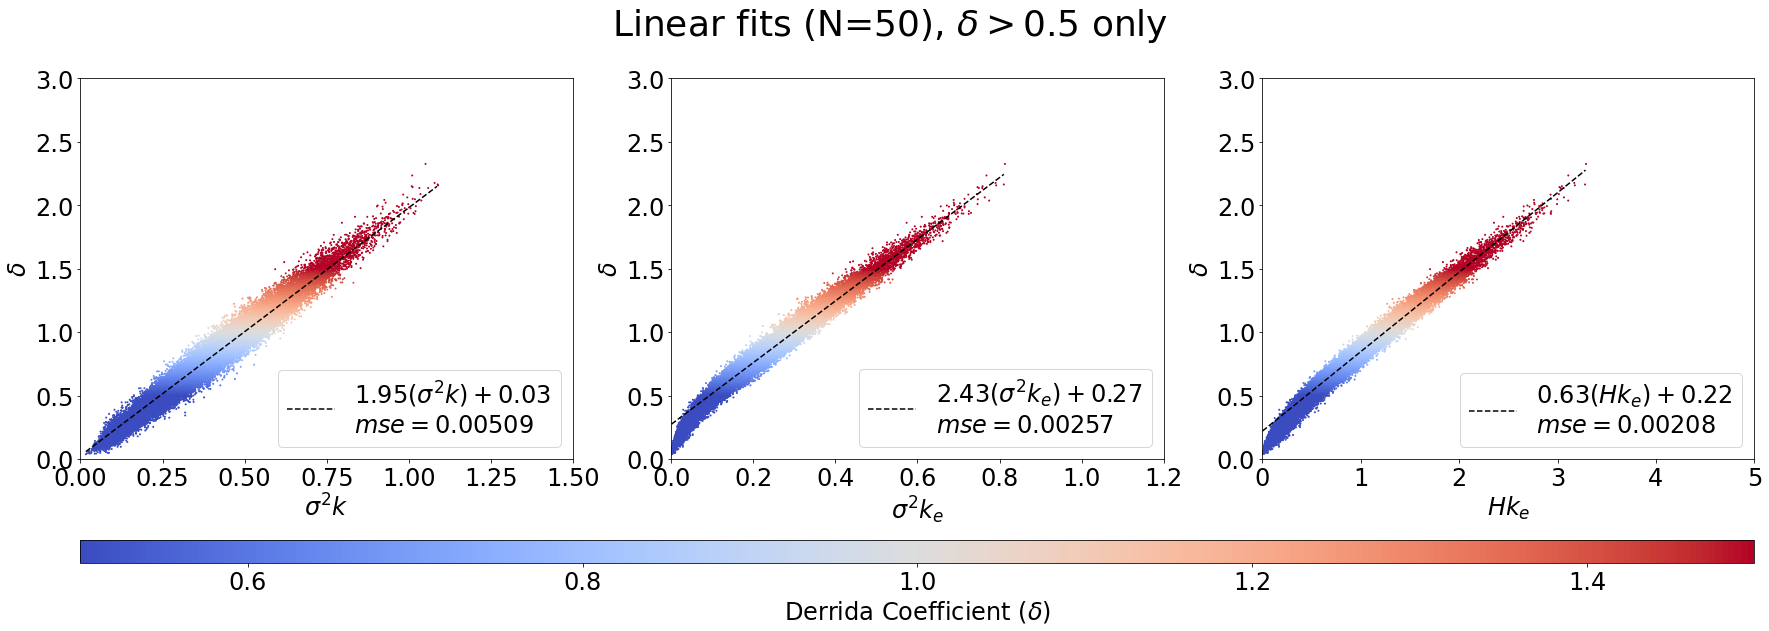

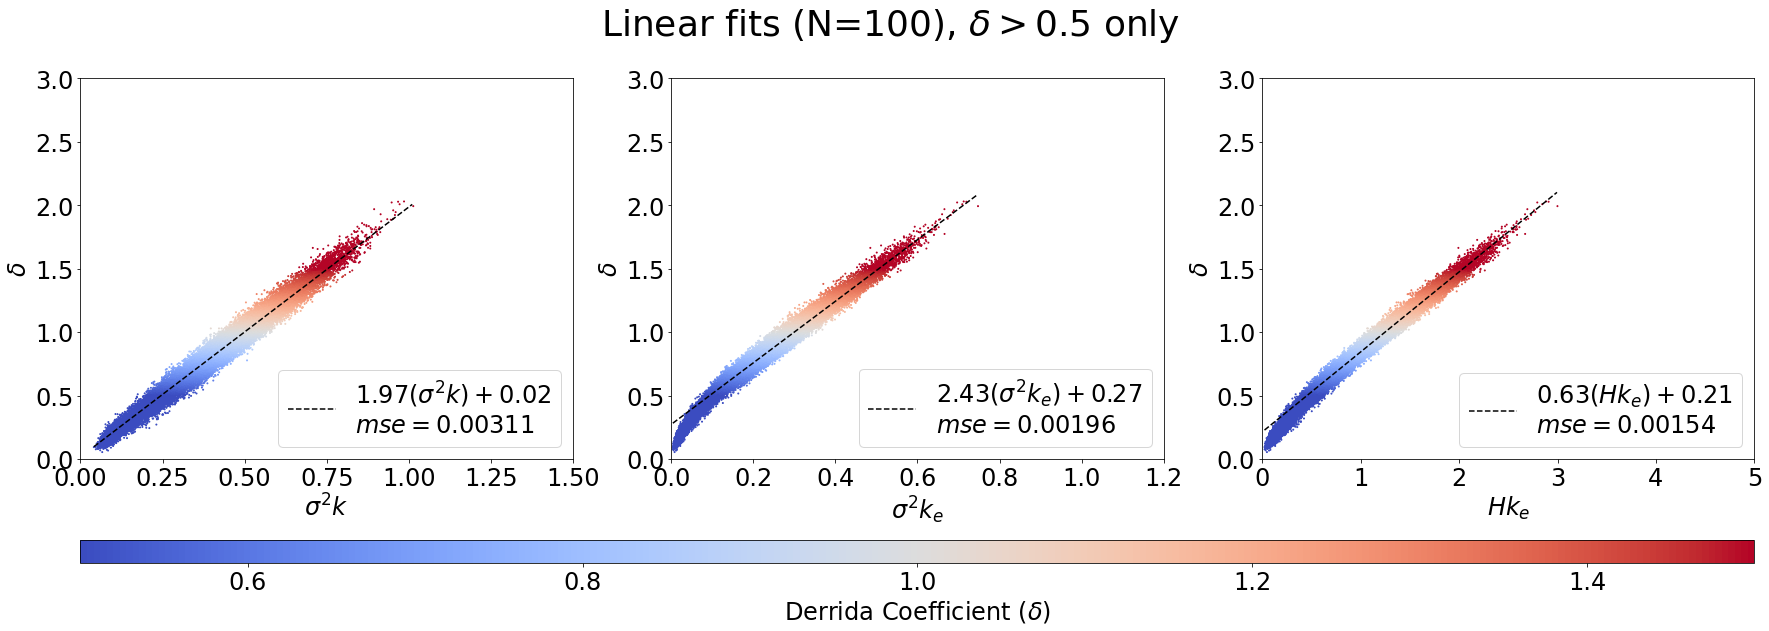

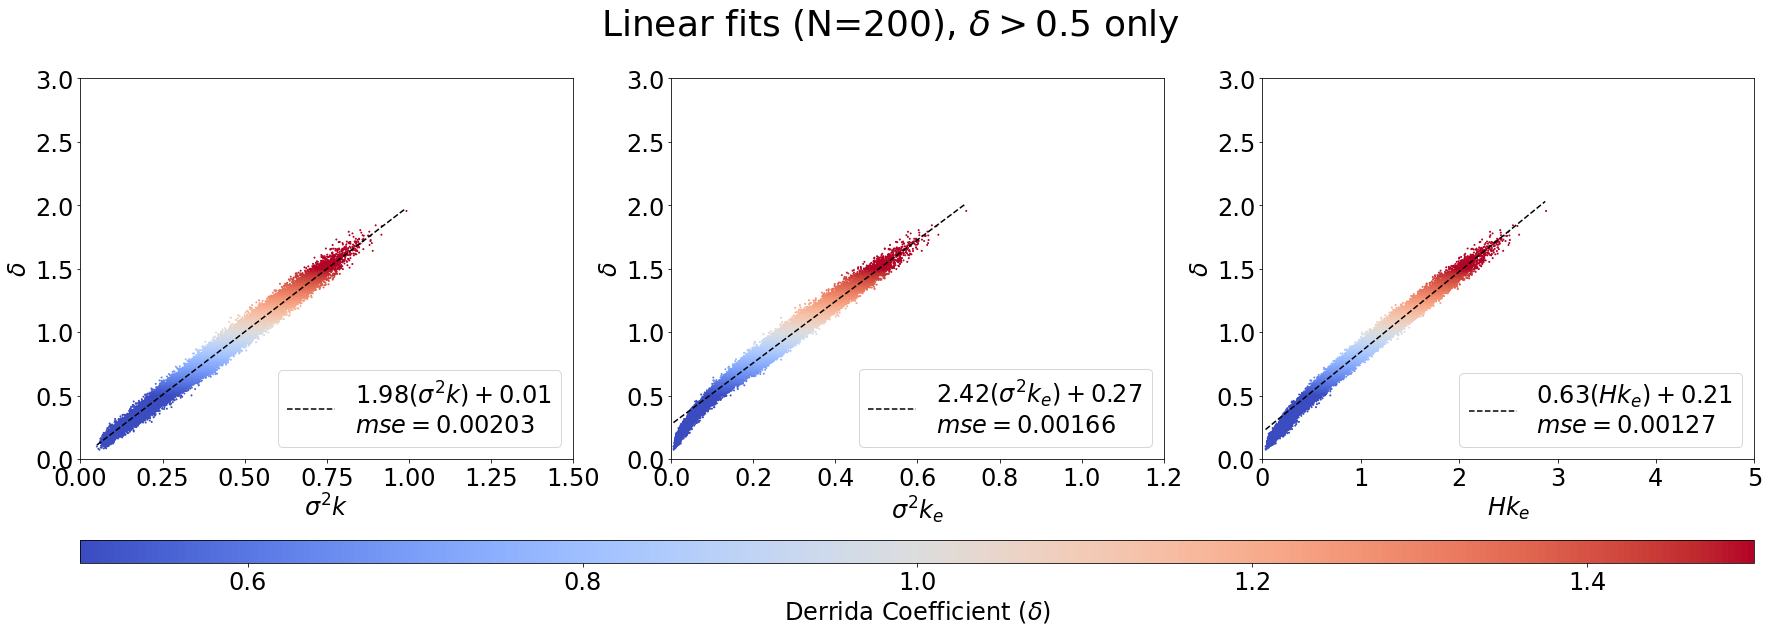

In [100]:
Nvals_test=[20,50]
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV'] / (dfN['Derrida']>0.5)
    y=dfN['Derrida']
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgK']*dfN['avgV']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dfN['Derrida']>0.5],dfN['Derrida'][dfN['Derrida']>0.5],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(\sigma^2 k)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2 k$",fontsize=fs)
    ax[0].set_ylabel("$\delta$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_ylim(0,3)
    ax[0].set_xlim(0,1.5)
    
    x=dfN['avgKe']*dfN['avgV'] / (dfN['Derrida']>0.5)
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgKe']*dfN['avgV']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dfN['Derrida']>0.5],dfN['Derrida'][dfN['Derrida']>0.5],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(\sigma^2 k_e)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2 k_e$",fontsize=fs)
    ax[1].set_ylabel("$\delta$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3)
    ax[1].set_xlim(0,1.2)
    
    x=dfN['avgKe']*dfN['avgH']
    x=dfN['avgKe']*dfN['avgH'] / (dfN['Derrida']>0.5)
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgKe']*dfN['avgH']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dfN['Derrida']>0.5],dfN['Derrida'][dfN['Derrida']>0.5],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(Hk_e)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$Hk_e$",fontsize=fs)
    ax[2].set_ylabel("$\delta$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3)
    ax[2].set_xlim(0,5)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Linear fits ({N=}), $\delta > 0.5$ only',fontsize=fs*1.5)
    plt.show()

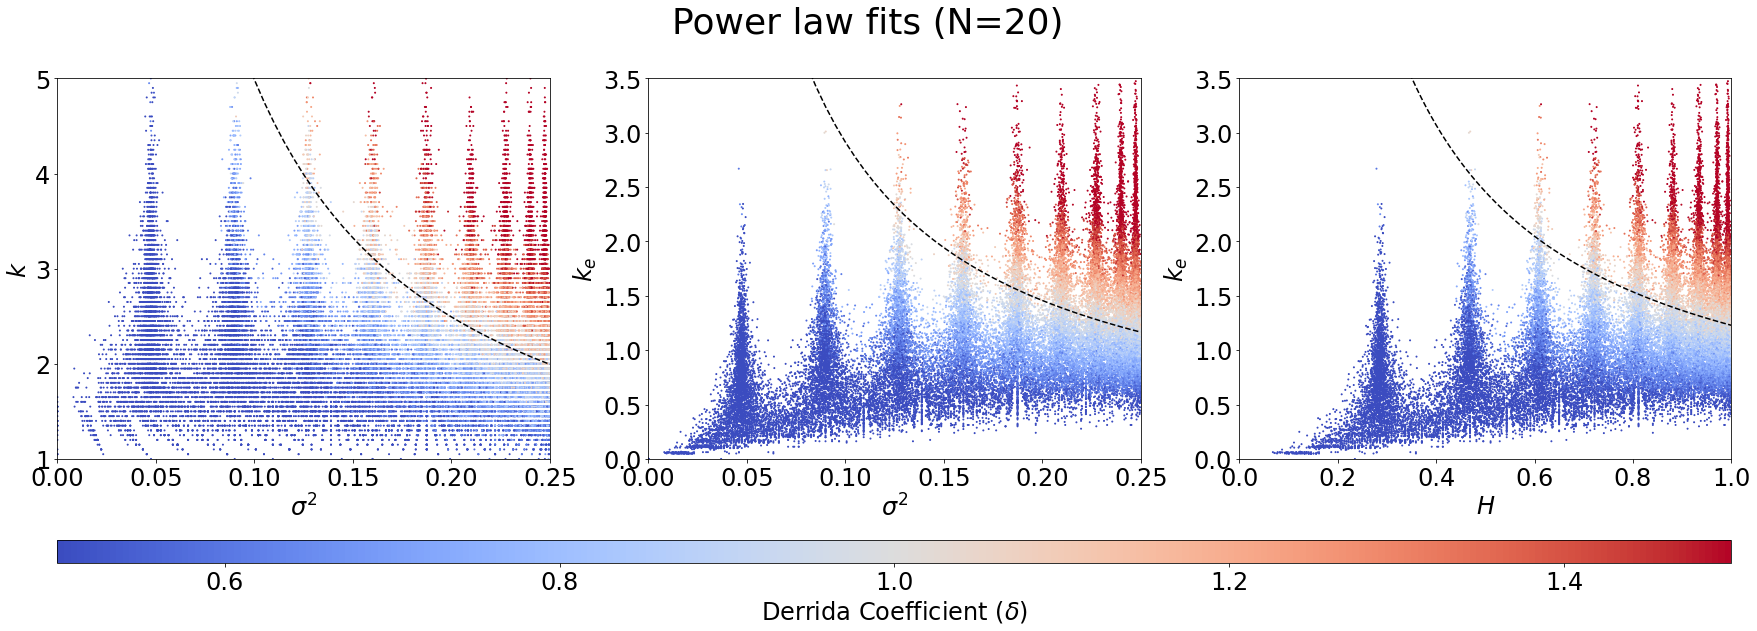

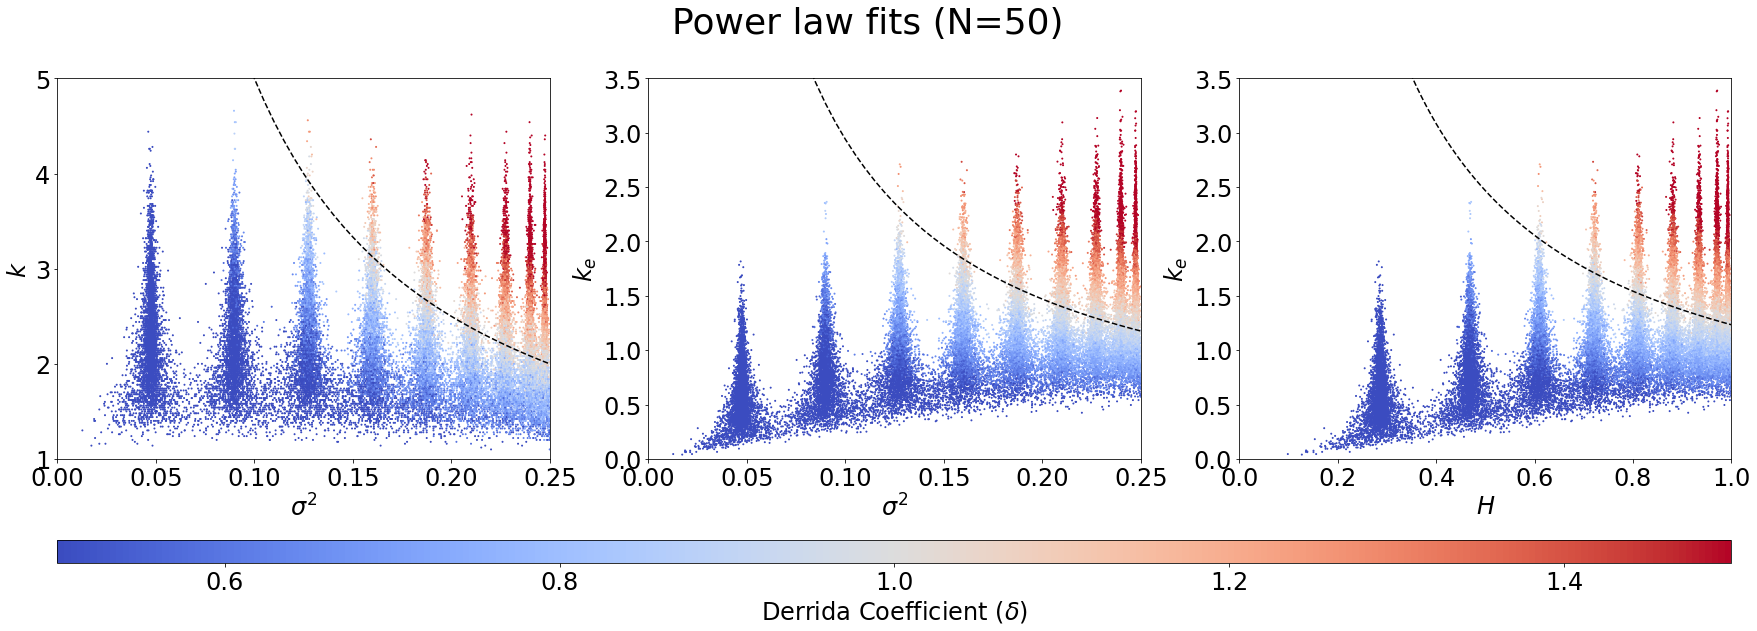

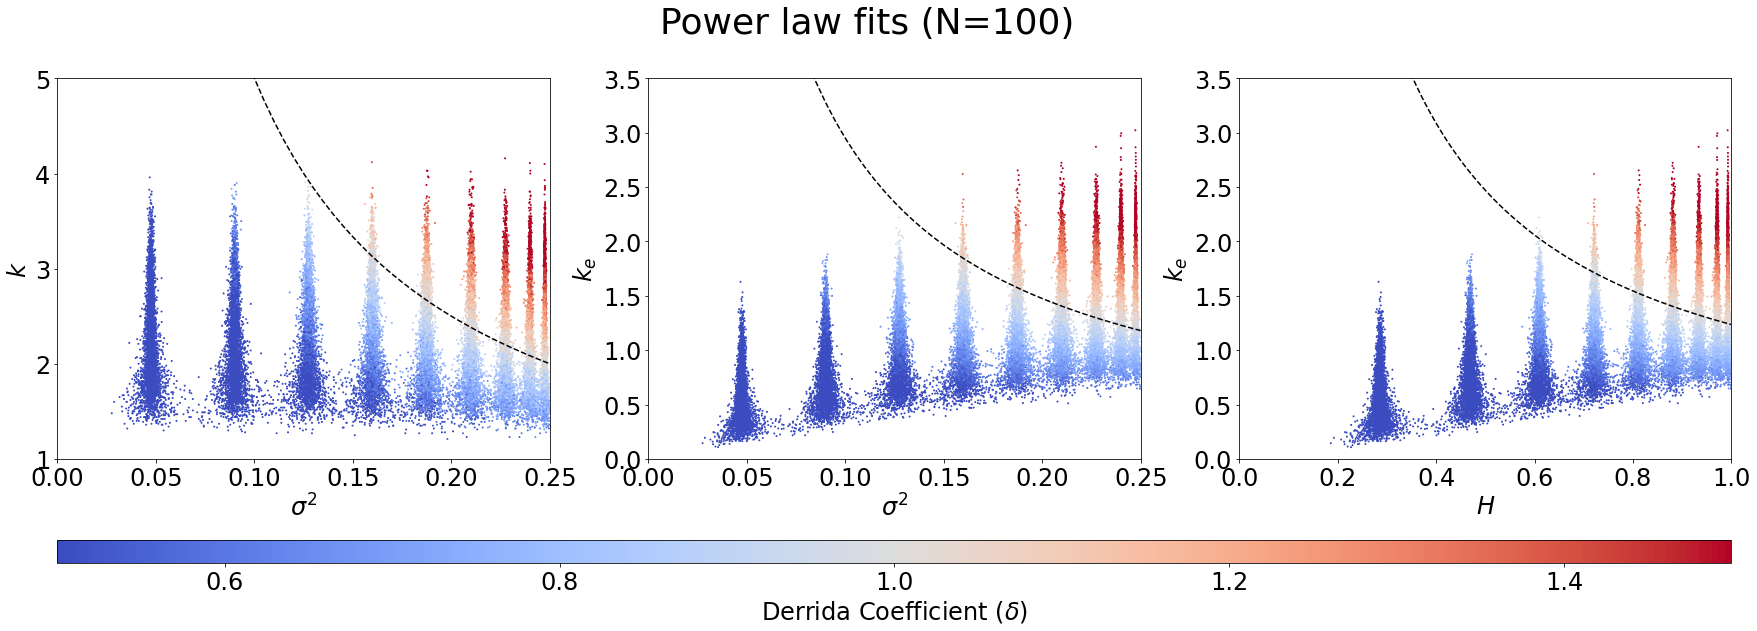

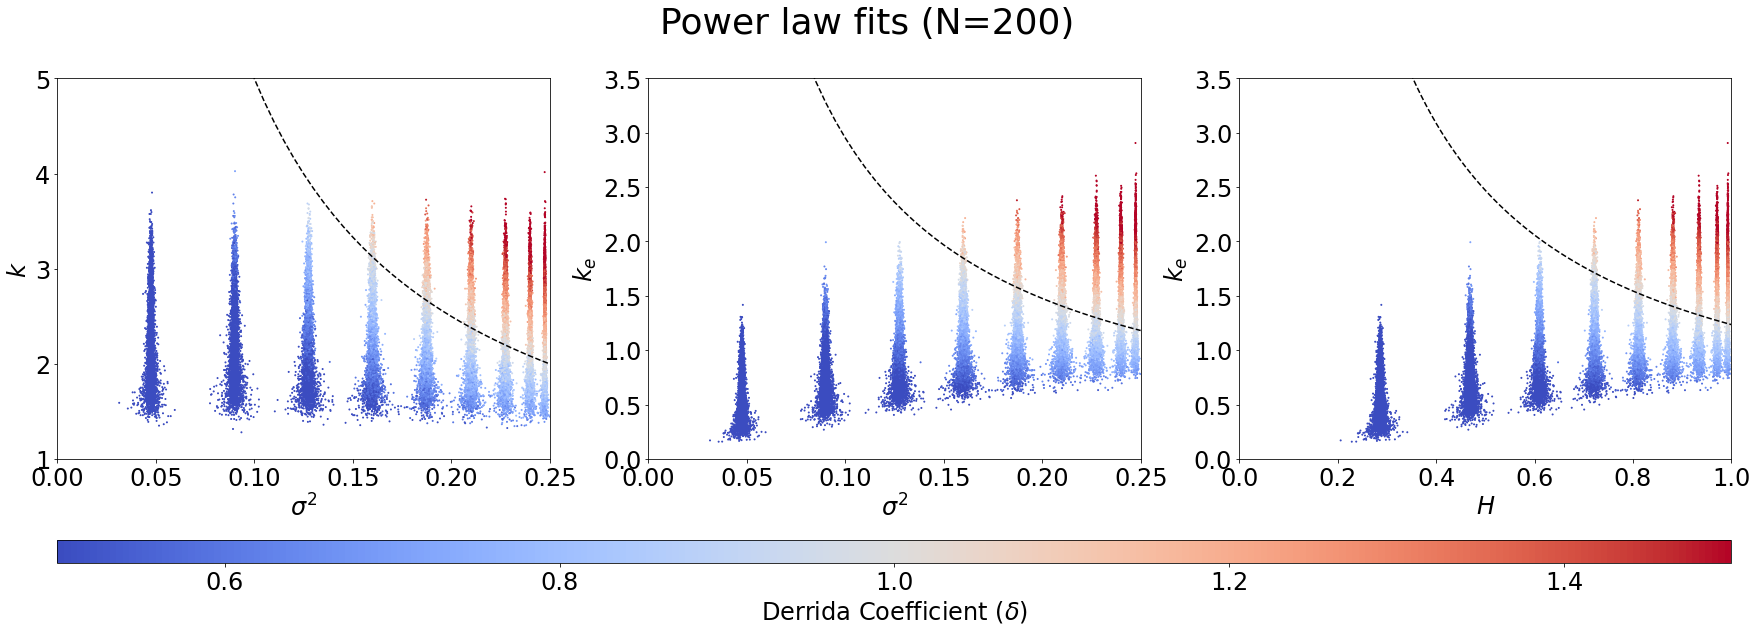

In [89]:
Nvals_test=[20,50]
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(0.005,0.255,0.005)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(dfN['avgV'], dfN['avgK'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2$",fontsize=fs)
    ax[0].set_ylabel("$k$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    #ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_xlim(0,0.25)
    ax[0].set_ylim(1,5)
    
    
    x=dfN['avgKe']*dfN['avgV']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(0.01,0.255,0.005)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(dfN['avgV'], dfN['avgKe'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2$",fontsize=fs)
    ax[1].set_ylabel("$k_e$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    #ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3.5)
    ax[1].set_xlim(0,0.25)
    
    x=dfN['avgKe']*dfN['avgH']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    xfit=np.arange(0.01,1.01,0.01)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(dfN['avgH'], dfN['avgKe'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$H$",fontsize=fs)
    ax[2].set_ylabel("$k_e$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    #ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3.5)
    ax[2].set_xlim(0,1)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Power law fits ({N=})',fontsize=fs*1.5)
    plt.show()

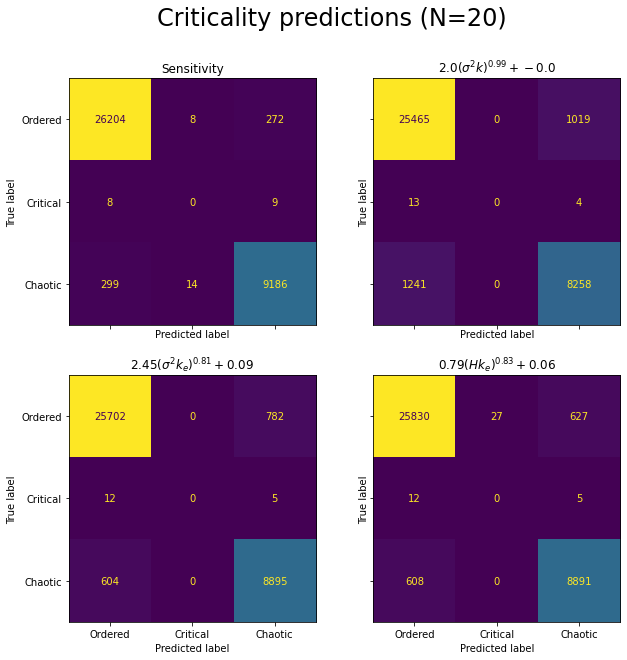

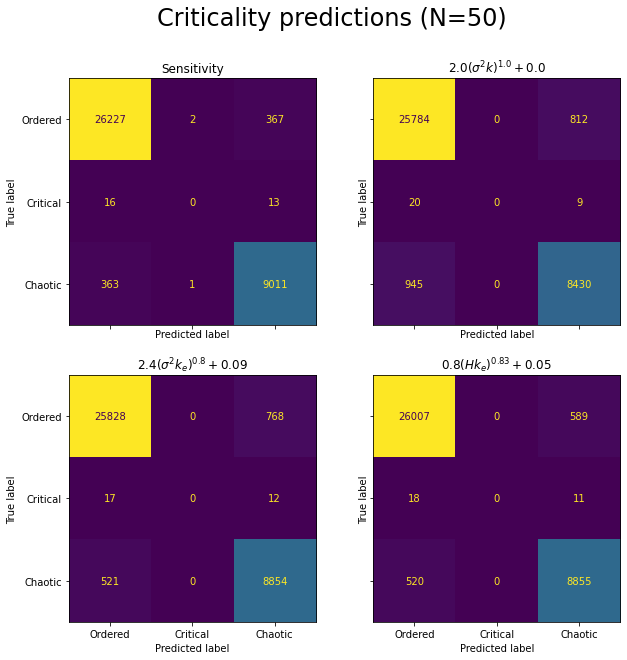

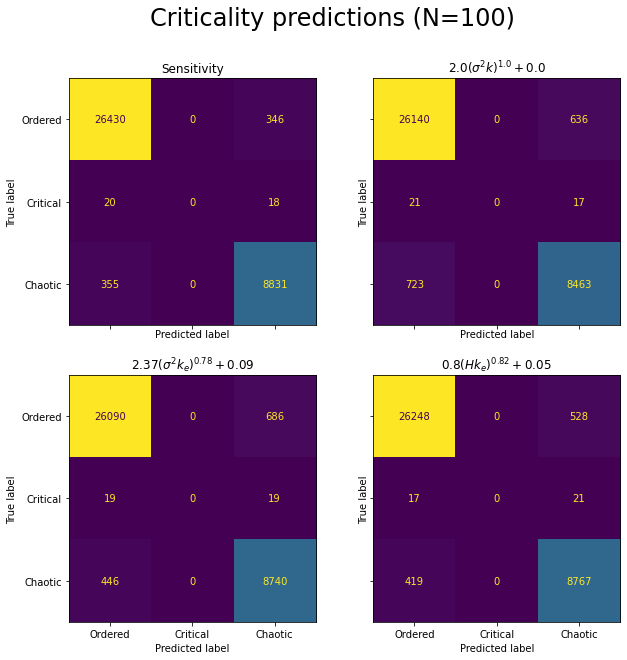

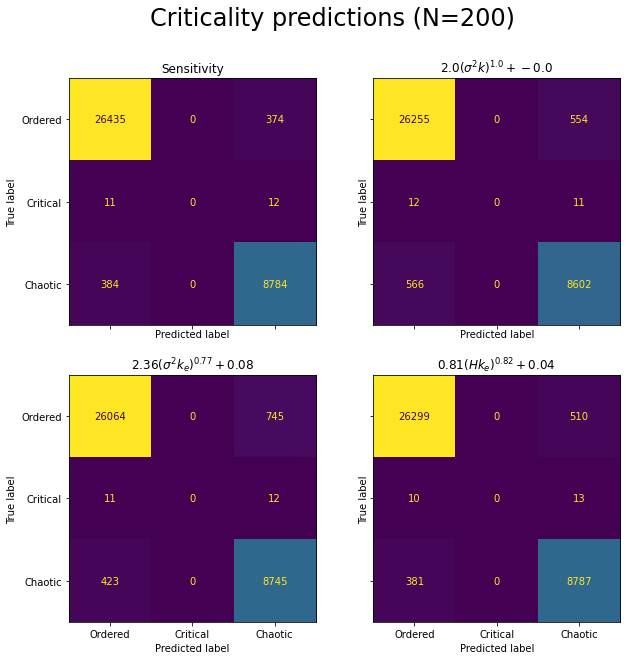

In [105]:
Nvals_test=[20]
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='col', facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    
    x=dfN['avgS']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,1,1,0)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[0,0])
    cm_display.im_.colorbar.remove()
    ax[0,0].set_title('Sensitivity')
    
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[0,1])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k)^{mstr}+{np.round(b,2)}$'
    ax[0,1].set_title(label)
    
    x=dfN['avgKe']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[1,0])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k_e)^{mstr}+{np.round(b,2)}$'
    ax[1,0].set_title(label)
    
    x=dfN['avgKe']*dfN['avgH']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[1,1])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(H k_e)^{mstr}+{np.round(b,2)}$'
    ax[1,1].set_title(label)
    
    fig.suptitle(f'Criticality predictions ({N=})',fontsize=fs)
    #fig.colorbar(cm_display.im_, ax=ax)
    plt.show()

In [11]:
dfcc = pd.read_csv('cc_network_data.csv')
dfcc['avgH'] = -np.log2(dfcc['bias'])*dfcc['bias'] - np.log2(1-dfcc['bias'])*(1-dfcc['bias'])
dfcc['avgV']=(1-dfcc['bias'])*dfcc['bias']

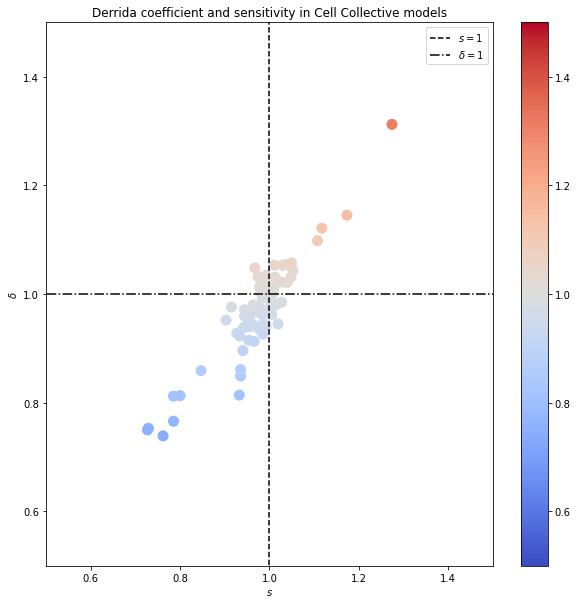

In [12]:
fig, ax = plt.subplots(figsize=(10, 10),facecolor='white')
ax.set_facecolor('white')
varx = 's'
vary = 'dc'
cmap = plt.cm.get_cmap('coolwarm')#.reversed()
sc=ax.scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax.vlines(1.0,0,2,label='$s=1$',color='k',linestyles='--')
ax.hlines(1.0,0,2,label='$\delta=1$',color='k',linestyles='-.')
ax.set_ylim(0.5,1.5)
ax.set_xlim(0.5,1.5)
plt.colorbar(sc)
plt.xlabel('$s$')
plt.ylabel('$\delta$')
plt.title('Derrida coefficient and sensitivity in Cell Collective models')
plt.legend()
plt.show()

In [92]:
print(dfcc['Nnodes'].mean())
print(dfcc['dc'].min())
print(dfcc['dc'].max())

46.78378378378378
0.739
1.312


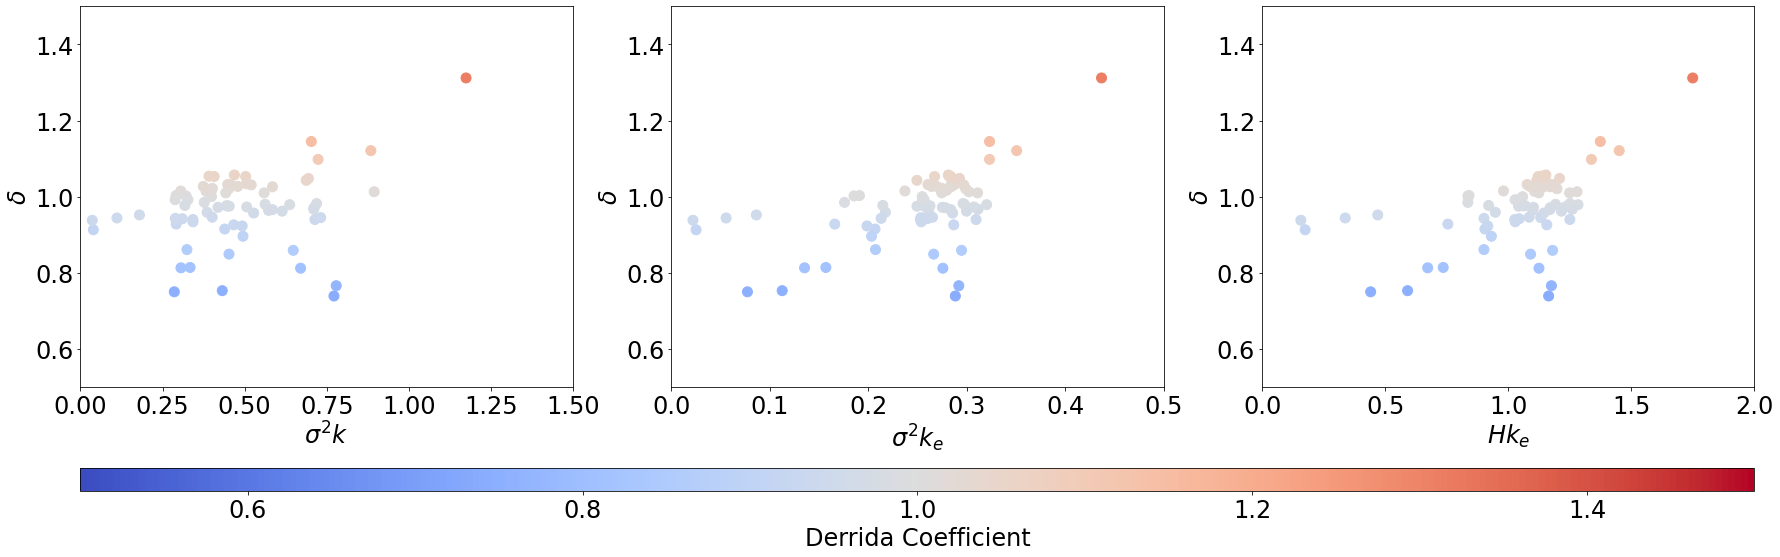

In [108]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
cmap = plt.cm.get_cmap('coolwarm')

sc=ax[0].scatter(dfcc['avgV']*dfcc['k'],dfcc['dc'],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[0].set_ylim(0.5,1.5)
ax[0].set_xlim(0,1.5)
#ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$\sigma^2 k$',fontsize=fs)
ax[0].set_ylabel('$\delta$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)

sc=ax[1].scatter(dfcc['avgV']*dfcc['ke'],dfcc['dc'],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[1].set_ylim(0.5,1.5)
ax[1].set_xlim(0,0.5)
#ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$\sigma^2 k_e$',fontsize=fs)
ax[1].set_ylabel('$\delta$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)

sc=ax[2].scatter(dfcc['avgH']*dfcc['ke'],dfcc['dc'],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[2].set_ylim(0.5,1.5)
ax[2].set_xlim(0,2)
#ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$H k_e$',fontsize=fs)
ax[2].set_ylabel('$\delta$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Derrida Coefficient',fontsize=fs)


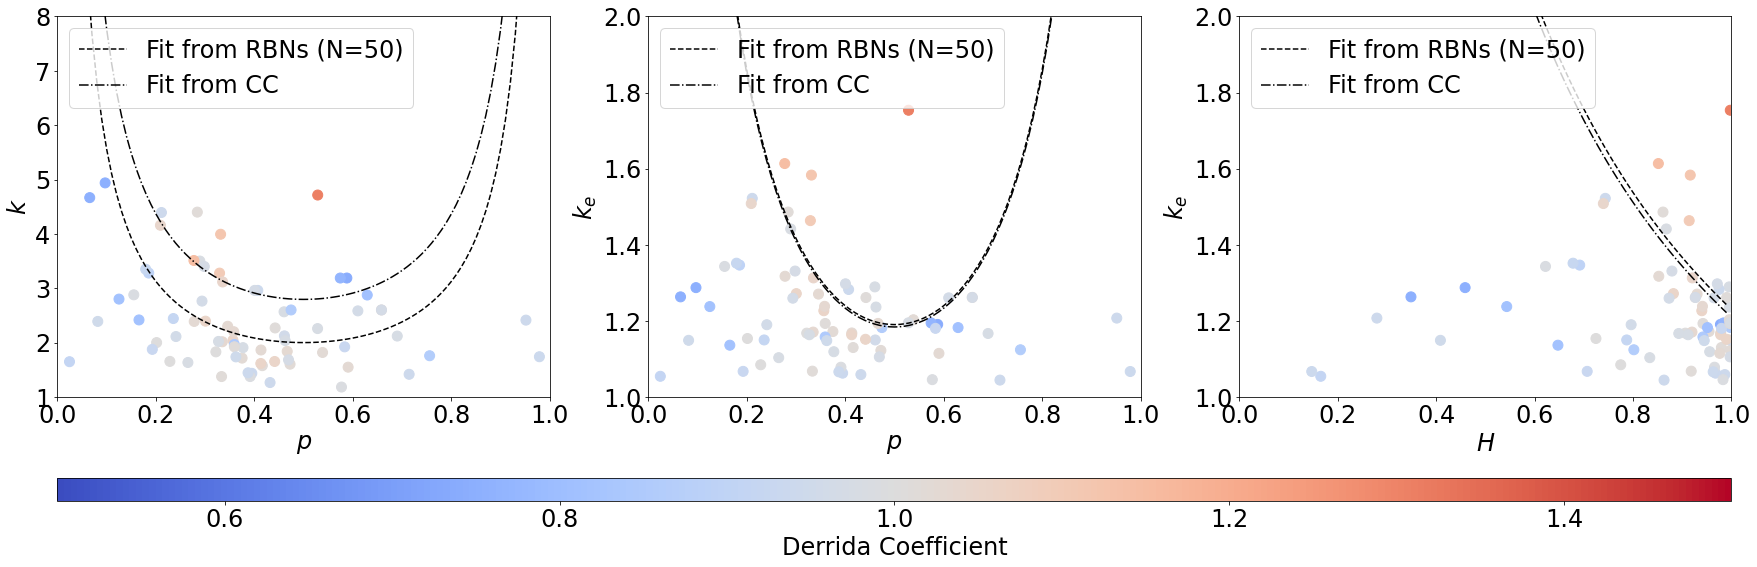

In [64]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
bounds = ([0,0,-0.1],[10,2,0.1]) #c,m,b
fs = 24
cmap = plt.cm.get_cmap('coolwarm')#.reversed()

varx = 'bias'
vary = 'k'

#popt, pcov = curve_fit(powerlaw,dfcc['k']*dfcc['avgV'],dfcc['dc'],bounds=bounds,p0=[2,1,0])
#c, m, b = popt
#print(c,m,b)
popt, pcov = curve_fit(linear_law,dfcc['k']*dfcc['avgV'],dfcc['dc'])
m, b = popt
sc=ax[0].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
#py=critical_kappa(px*(1-px),c,m,b)
py=critical_kappa_lin(px*(1-px),m,b)
py2=critical_kappa(px*(1-px),2,1,0)
ax[0].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[0].plot(px,py,'-.k',label='Fit from CC')
ax[0].set_ylim(1,8)
ax[0].set_xlim(0,1)
ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$p$',fontsize=fs)
ax[0].set_ylabel('$k$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)

varx = 'bias'
vary = 'ke'

# popt, pcov = curve_fit(powerlaw,dfcc['ke']*dfcc['avgV'],dfcc['dc'],bounds=bounds,p0=[2.4,0.8,0.09])
# c, m, b = popt
# print(c,m,b)
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgV'],dfcc['dc'])
m, b = popt
sc=ax[1].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
#py=critical_kappa(px*(1-px),c,m,b)
py=critical_kappa_lin(px*(1-px),m,b)
py2=critical_kappa(px*(1-px),2.4,0.8,0.09)
ax[1].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[1].plot(px,py,'-.k',label='Fit from CC')
ax[1].set_ylim(1,2)
ax[1].set_xlim(0,1)
ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$p$',fontsize=fs)
ax[1].set_ylabel('$k_e$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)

varx = 'avgH'
vary = 'ke'
# popt, pcov = curve_fit(powerlaw,dfcc['ke']*dfcc['avgH'],dfcc['dc'],bounds=bounds,p0=[0.8,0.83,0.05])
# c, m, b = popt
# print(c,m,b)
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgH'],dfcc['dc'])
m, b = popt
sc=ax[2].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0,label=None)
px = np.arange(0.01,1,0.01)
#pxH= -px*np.log2(px)-(1-px)*np.log2(1-px)
#py=critical_kappa(px,c,m,b)
py=critical_kappa_lin(px,m,b)
py2=critical_kappa(px,0.8,0.83,0.05)
ax[2].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[2].plot(px,py,'-.k',label='Fit from CC')
ax[2].set_ylim(1,2)
ax[2].set_xlim(0,1)
ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$H$',fontsize=fs)
ax[2].set_ylabel('$k_e$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Derrida Coefficient',fontsize=fs)

plt.show()

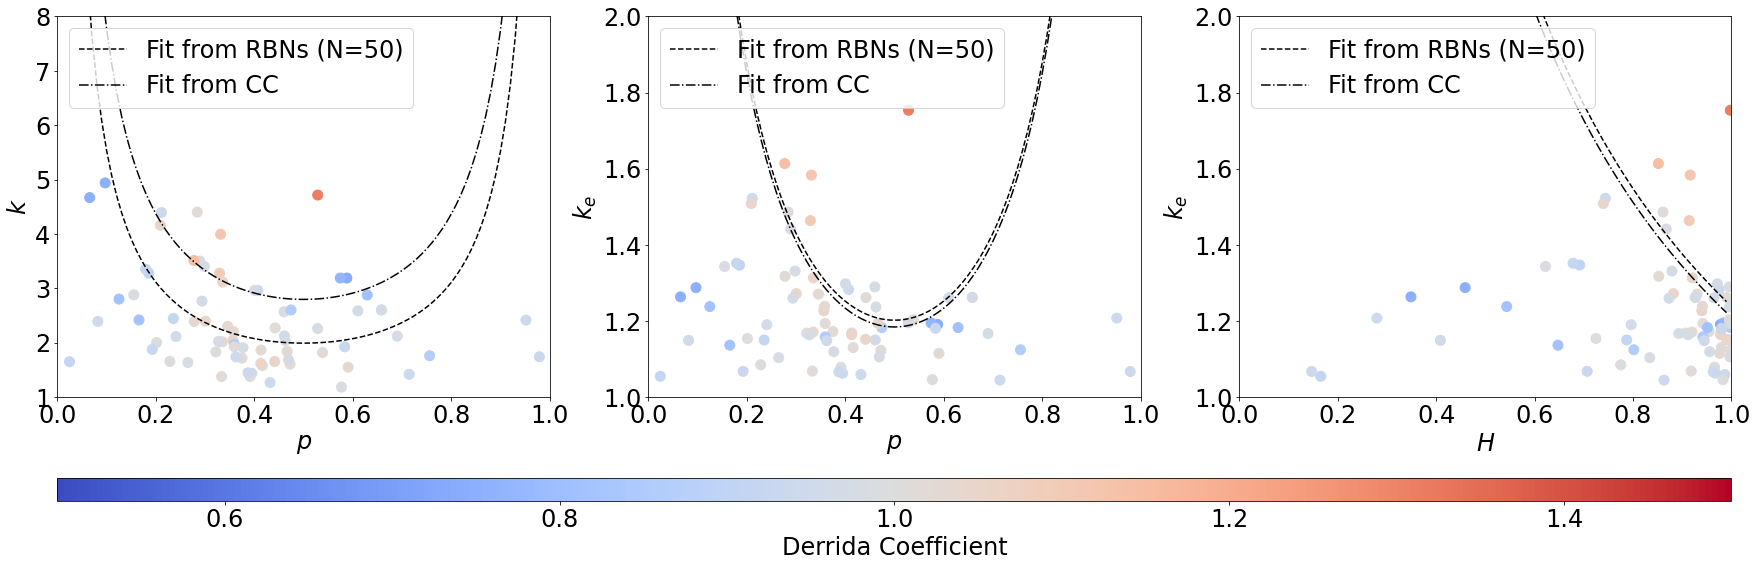

In [101]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
bounds = ([0,0,-0.1],[10,2,0.1]) #c,m,b
fs = 24
cmap = plt.cm.get_cmap('coolwarm')#.reversed()

varx = 'bias'
vary = 'k'

#popt, pcov = curve_fit(powerlaw,dfcc['k']*dfcc['avgV'],dfcc['dc'],bounds=bounds,p0=[2,1,0])
#c, m, b = popt
#print(c,m,b)
popt, pcov = curve_fit(linear_law,dfcc['k']*dfcc['avgV'],dfcc['dc'])
m, b = popt
sc=ax[0].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
#py=critical_kappa(px*(1-px),c,m,b)
py=critical_kappa_lin(px*(1-px),m,b)
py2=critical_kappa_lin(px*(1-px),1.95,0.03)
ax[0].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[0].plot(px,py,'-.k',label='Fit from CC')
ax[0].set_ylim(1,8)
ax[0].set_xlim(0,1)
ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$p$',fontsize=fs)
ax[0].set_ylabel('$k$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)

varx = 'bias'
vary = 'ke'

# popt, pcov = curve_fit(powerlaw,dfcc['ke']*dfcc['avgV'],dfcc['dc'],bounds=bounds,p0=[2.4,0.8,0.09])
# c, m, b = popt
# print(c,m,b)
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgV'],dfcc['dc'])
m, b = popt
sc=ax[1].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
#py=critical_kappa(px*(1-px),c,m,b)
py=critical_kappa_lin(px*(1-px),m,b)
py2=critical_kappa_lin(px*(1-px),2.43,0.27)
ax[1].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[1].plot(px,py,'-.k',label='Fit from CC')
ax[1].set_ylim(1,2)
ax[1].set_xlim(0,1)
ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$p$',fontsize=fs)
ax[1].set_ylabel('$k_e$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)

varx = 'avgH'
vary = 'ke'
# popt, pcov = curve_fit(powerlaw,dfcc['ke']*dfcc['avgH'],dfcc['dc'],bounds=bounds,p0=[0.8,0.83,0.05])
# c, m, b = popt
# print(c,m,b)
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgH'],dfcc['dc'])
m, b = popt
sc=ax[2].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0,label=None)
px = np.arange(0.01,1,0.01)
#pxH= -px*np.log2(px)-(1-px)*np.log2(1-px)
#py=critical_kappa(px,c,m,b)
py=critical_kappa_lin(px,m,b)
py2=critical_kappa_lin(px,0.63,0.22)
ax[2].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[2].plot(px,py,'-.k',label='Fit from CC')
ax[2].set_ylim(1,2)
ax[2].set_xlim(0,1)
ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$H$',fontsize=fs)
ax[2].set_ylabel('$k_e$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Derrida Coefficient',fontsize=fs)

plt.show()

2 1 0
2.4 0.8 0.09
0.8 0.83 0.05


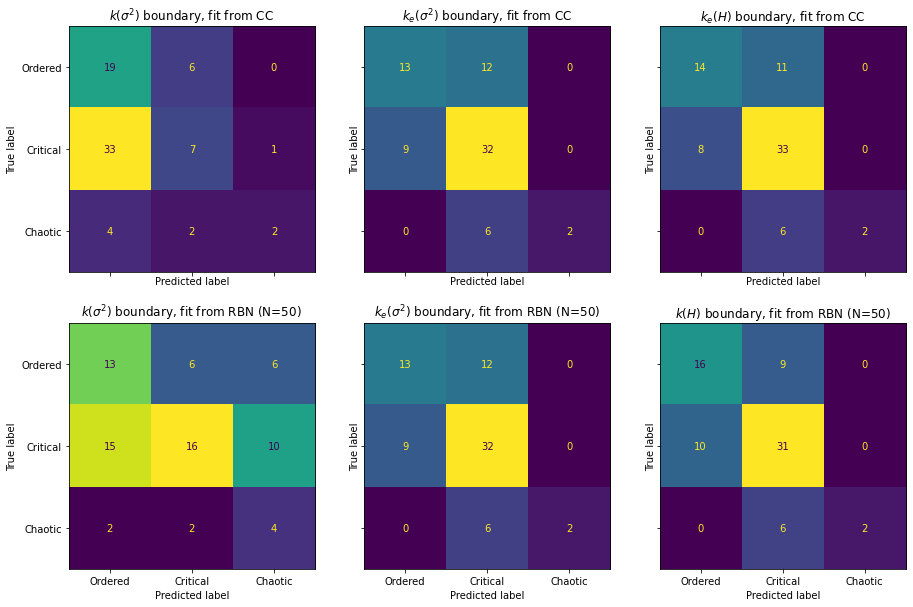

In [104]:

fs = 24
critical_range = 0.05
truth = (dfcc['dc'] > (1+critical_range)).astype(int) - \
    (dfcc['dc'] < (1-critical_range)).astype(int)
critical_range = 0.15
fig, ax = plt.subplots(2, 3, figsize=(
    15, 10), sharey='row', sharex='col', facecolor='white')

x = dfcc['k']*dfcc['avgV']
# popt, pcov = curve_fit(powerlaw, x, dfcc['dc'], bounds=bounds, p0=[2, 1, 0])
# c, m, b = popt
# print(c, m, b)
#yfit = powerlaw(x, c, m, b)
popt, pcov = curve_fit(linear_law,dfcc['k']*dfcc['avgV'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)

#dkappa=dfcc['k']/critical_kappa(dfcc['avgV'],c,m,b)-1
dkappa=dfcc['k']/critical_kappa_lin(dfcc['avgV'],m,b)-1
preds=(dkappa > (critical_range)).astype(int) - \
    (dkappa < (-critical_range)).astype(int)
    
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[0, 0])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$k(\sigma^2)$ boundary, fit from CC'
ax[0, 0].set_title(label)

x = dfcc['ke']*dfcc['avgV']
# popt, pcov = curve_fit(
#     powerlaw, x, dfcc['dc'], bounds=bounds, p0=[2.4, 0.8, 0.09])
# c, m, b = popt
# print(c, m, b)
# yfit = powerlaw(x, c, m, b)
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgV'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
#dkappa=dfcc['ke']/critical_kappa(dfcc['avgV'],c,m,b)-1
dkappa=dfcc['ke']/critical_kappa_lin(dfcc['avgV'],m,b)-1
preds=(dkappa > (critical_range)).astype(int) - \
    (dkappa < (-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[0, 1])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$k_e(\sigma^2)$ boundary, fit from CC'
ax[0, 1].set_title(label)

x = dfcc['ke']*dfcc['avgH']
# popt, pcov = curve_fit(
#     powerlaw, x, dfcc['dc'], bounds=bounds, p0=[0.8, 0.83, 0.05])
# c, m, b = popt
# print(c, m, b)
# yfit = powerlaw(x, c, m, b)
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgH'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
# dkappa=dfcc['ke']/critical_kappa(dfcc['avgH'],c,m,b)-1
dkappa=dfcc['ke']/critical_kappa_lin(dfcc['avgH'],m,b)-1
preds=(dkappa > (critical_range)).astype(int) - \
    (dkappa < (-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[0, 2])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$k_e(H)$ boundary, fit from CC'
ax[0, 2].set_title(label)

x = dfcc['k']*dfcc['avgV']
c, m, b = (2, 1, 0)
print(c, m, b)
yfit = powerlaw(x, c, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
dkappa=dfcc['k']/critical_kappa(dfcc['avgV'],c,m,b)-1
preds=(dkappa > (critical_range)).astype(int) - \
    (dkappa < (-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 0])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$k(\sigma^2)$ boundary, fit from RBN (N=50)'
ax[1, 0].set_title(label)

x = dfcc['ke']*dfcc['avgV']
c, m, b = (2.4, 0.8, 0.09)
print(c, m, b)
yfit = powerlaw(x, c, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
dkappa=dfcc['ke']/critical_kappa(dfcc['avgV'],c,m,b)-1
preds=(dkappa > (critical_range)).astype(int) - \
    (dkappa < (-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 1])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$k_e(\sigma^2)$ boundary, fit from RBN (N=50)'
ax[1, 1].set_title(label)

x = dfcc['ke']*dfcc['avgH']
c, m, b = (0.8, 0.83, 0.05)
print(c, m, b)
yfit = powerlaw(x, c, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
dkappa=dfcc['ke']/critical_kappa(dfcc['avgH'],c,m,b)-1
preds=(dkappa > (critical_range)).astype(int) - \
    (dkappa < (-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 2])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$k(H)$ boundary, fit from RBN (N=50)'
ax[1, 2].set_title(label)

#fig.suptitle(f'Criticality predictions', fontsize=fs)
#fig.colorbar(cm_display.im_, ax=ax)
plt.show()


### Notes on above figure:
For the "true lable", we're using the Derrida coefficient. Values between $0.95$ and $1.05$ are "critical", values above (below) this range are chaotic (ordered).

For the "predicted label", we're using the fractional difference between the observed and critical (fit) $k$ or $k_e$ values to assign labels (e.g., $(k_{obs}-k_{theor})/(k_{theor})$). If the fractional difference is between $\pm 0.15$, it is called critical. Observed degree parameters above (below) this range are chaotic (ordered).